In [6]:
#import packages
import pandas as pd
import numpy as np
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import codecs
import string
import os
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split

from keras.preprocessing import sequence

Using TensorFlow backend.


ImportError: No module named 'tensorflow'

In [2]:
#load data
df = pd.read_csv('Clean_text.csv')

In [3]:
df.head()

,no,jflo_id,y,text
0,1,BNEF-129035,Rejected,plans to build the northern territorys largest...
1,2,BNEF-129013,Rejected,pv project developer and epc firm juwi renewab...
2,3,BNEF-128999,Rejected,the area outlined in yellow is where nextera e...
3,4,BNEF-128966,Rejected,in a report released by the u s department of ...
4,5,BNEF-128953,Rejected,by jeremy hodge bloomberg hsbc holdings plc pl...


## Text cleaning  

In [4]:
#first row 
isinstance(df['y'][1], basestring)

def remove_spec(text):
  return re.sub("[\x9d|\x9c|\xa0]", '', text)
  
df['text'] = df['text'].apply(remove_spec)
#df['text'].iloc[0] -- check if removed

In [5]:
def remove_spec(text):
  return re.sub("[\x9d|\x9c|\xa0]", '', text)
  
df['text'] = df['text'].apply(remove_spec)

In [6]:
df['length'] = df['text'].apply(len)
# what are our longest sentences?
df.sort_values(by='length', ascending=False).head(10)

,no,jflo_id,y,text,length
146,147,BNEF-127974,Rejected,abstract thursday october 11 201 china water a...,20454
145,146,BNEF-127975,Rejected,abstract thursday october 11 201 china water a...,20454
144,145,BNEF-127976,Rejected,abstract thursday october 11 201 china water a...,20454
143,144,BNEF-127977,Rejected,abstract thursday october 11 201 china water a...,20454
1831,1832,BNEF-121516,Rejected,abstract tuesday september 18 201 european bus...,17735
1830,1831,BNEF-121518,Rejected,abstract tuesday september 18 201 european bus...,17735
1633,1634,BNEF-122181,Completed,overvie limited purpose entity solaben luxembo...,16301
1328,1329,BNEF-123310,Rejected,for two years sean harris was of the opinion t...,15054
685,686,BNEF-125878,Completed,record of decision for the final environmental...,13842
1016,1017,BNEF-124446,Rejected,html body link type text css rel stylesheet h...,11303


In [7]:
# what are our shortest sentences?
df.sort_values(by='length').head(5)

,no,jflo_id,y,text,length
2214,2215,BNEF-120088,Rejected,merger to boost the pairs presence in wind and...,101
2001,2002,BNEF-120891,Rejected,limes renewables energy is seeking a financial...,101
2004,2005,BNEF-120888,Rejected,solar energy corporation of india has extended...,102
38,39,BNEF-128743,Rejected,in depth up to eight chinese manufacturers are...,106
1324,1325,BNEF-123341,Completed,french energy group to sell electricity from b...,107


### Train/Test Split

In [7]:
#split the data into training and test data 
train, test, _, _ = train_test_split(df[['y', 'text']],
                                     df['y'],
                                     test_size=0.20,
                                     random_state=80)

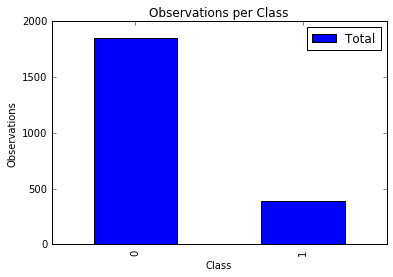

In [8]:
#checking for class imbalance
df2 = pd.DataFrame([], columns=['Class','Total'])
df2['Class'] = ["Rejected","Completed"]
df2['Total'] = [pd.value_counts(train['y'])[0],pd.value_counts(train['y'])[1]]
df2.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Observations')
plt.title('Observations per Class') #We therefore have imnbalanced classes, but we will continue regarless

Check the distribution item word counts below:

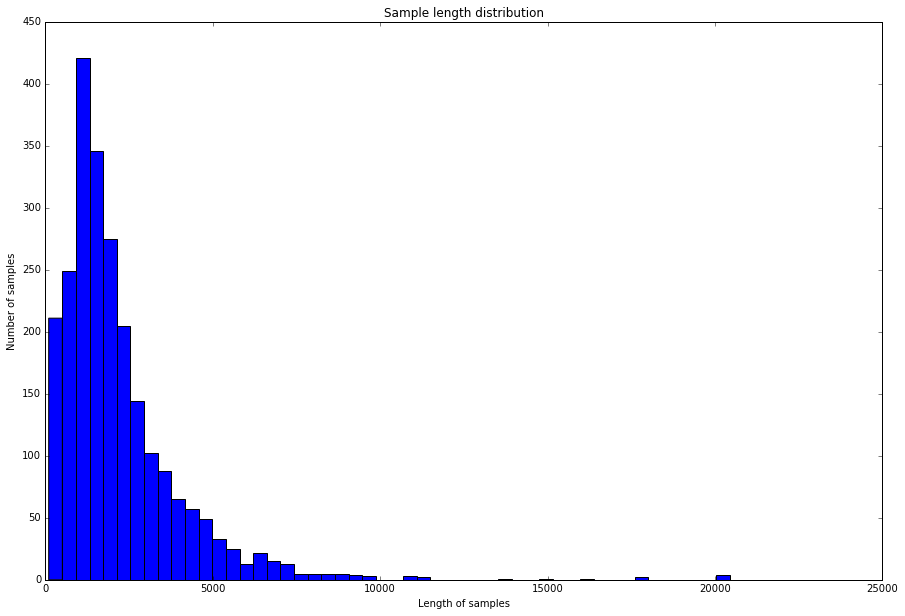

In [10]:
plt.figure(figsize=(15, 10))
plt.hist([len(sample) for sample in list(train['text'])], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

### Tokenize the text

At this stage, the data is still in text format. The next step is to 'numericalize' the data.This process is known as tokenizing, which simply means to create a set of unique IDs to represent all of the words in the corpus.

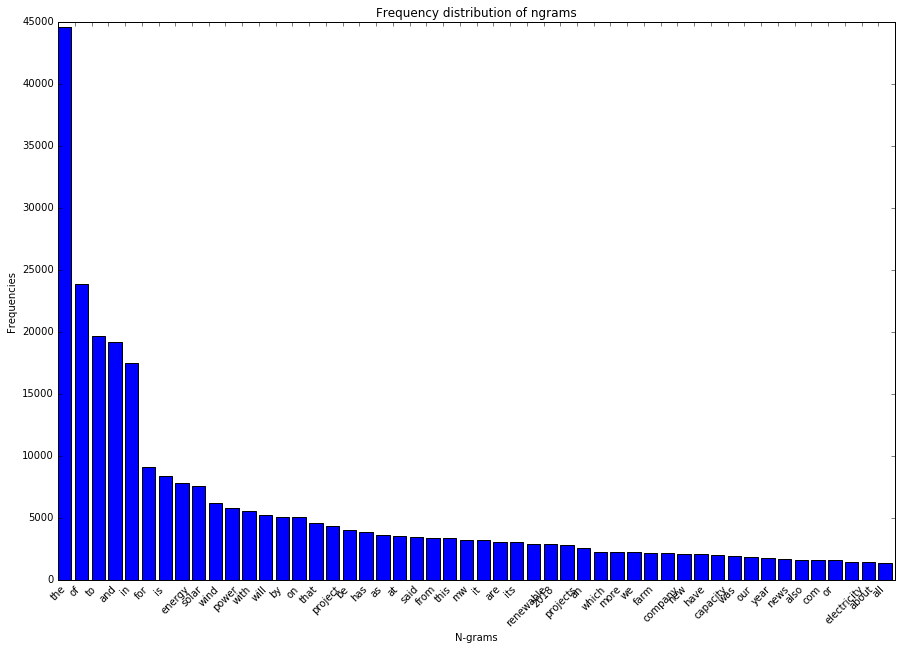

In [10]:
kwargs = {
    'ngram_range' : (1, 1),
    'dtype' : 'int32',
    'strip_accents' : 'unicode',
    'decode_error' : 'replace',
    'analyzer' : 'word'
}

vectorizer = CountVectorizer(**kwargs)
vect_texts = vectorizer.fit_transform(list(train['text']))
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

plt.figure(figsize=(15, 10))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

### Prepare data for model

In [11]:
# load whole corpus of words
all_text = df['text'].values
#Total number of words 
sum(counts)

281567

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ,
    }
    
    # Learn Vocab from train texts and vectorize train and val sets
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    x_train = tfidf_vectorizer.fit_transform(train_texts)
    x_val = tfidf_vectorizer.transform(val_texts)
    
    # Select best k features, with feature importance measured by f_classif
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [20]:
x_train, x_val = ngram_vectorize(train['text'],train['y'], test['text'])

## Model 1 - Simple Neual Network

In [ ]:
model_1=Sequential()
model_1.add(Dense(64, input_dim=max_words, activation='relu'))
model_1.add(Dropout(0.05))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dropout(0.25))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(6, activation='softmax'))

print(model_1.summary())